In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import pandas as pd
import re

# Elbow Method
One way to decide K for K-means clustering
Reference from:
https://pythonprogramminglanguage.com/kmeans-elbow-method/

In [2]:
#========= functions from MRT1
# I Elbow method for single station

def get_df_max(df):
    max_value = 0
    for item in df.columns:
        if df[item].max() > max_value:
            max_value = df[item].max()
    return max_value

def normalize_df(df):
    return round(df/get_df_max(df),2)*100

def station_table_to_list(station_sum_up):
    #1 normalizing data
    normalize = round(station_sum_up/get_df_max(station_sum_up),2)
    #2 transform to a list of lists
    middle_list = normalize.values.tolist()
    #3 transform to a single list
    result_list = [item for sub in middle_list for item in sub]
    
    return result_list

#=======================================

def multi_zips(length_ref,lists):
    X2 = []
    for i in range(len(length_ref)):
        item_list = []
        for lst in lists:
            item_list.append(lst[i])
        X2.append(item_list)
    return np.array(X2)

In [11]:
#==== testing with od table
#1. get full od list
def get_od_list():
    #os.chdir('D:\OBS\捷運分時')

    keep_cols = ['code_entrance','code_exit']
    df_ods = pd.read_csv('201806_MRT_hourly.csv',usecols=keep_cols)
    df_ods['code_from_to'] = df_ods['code_entrance'].str.cat(df_ods['code_exit'],sep='_')
    od_list = df_ods['code_from_to'].unique()

    #os.chdir('D:/OBS/捷運分時/time_by_od')
    print('get_od_list Done')
    return od_list


#2. slice wanted ods
def od_slicer(slicer,od_list):
    result = []
    #pattern = re.compile('{}_.*|.*_{}'.format(slicer,slicer))
    for od in od_list:
        if slicer[0] == '_':
            pattern = re.compile('{}$'.format(slicer))
            if re.search(pattern, od):
                result.append(od)
        else:
            if re.match(slicer, od):
                result.append(od)
    return result

#3. generate test array
def elbow_list(processed_list):
    #processed_list

    table = []
    count = 0
    for od in processed_list:
        od_dict = {}
        count += 1
        progress = round(count/len(processed_list)*100,2)
        #sys.stdout.write('\rprocessing od {} {}, {} %'.format(od,count,progress))

        df = pd.read_csv('OD_folder/{}.csv'.format(od),index_col=0,skiprows=[0,2],engine='python')

        #df = normalize_df(df)
        lst = station_table_to_list(df)
        od_dict[od] = lst
        table.append(od_dict)

    lists = []   
    for dic in table:
        for k,v in dic.items():
            lists.append(v)
    test_data = multi_zips(lists[0],lists)
    #print('\nnumber of ods: {}'.format(len(test_data[0])))
    return test_data

#4. k means determine k
def k_determiner(elbow_list,K):
    distortions = []
    #K = range(1,10)
    for k in K:
        #sys.stdout.write('\rprocessing K: {}'.format(k))
        kmeanModel = KMeans(n_clusters=k).fit(elbow_list)
        kmeanModel.fit(elbow_list)
        distortions.append(sum(np.min(cdist(elbow_list, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / elbow_list.shape[0])
    return distortions

#5. Plot the elbow
def plot(distortions_asO,distortions_asD, K, slicer):
    plt.figure(1, figsize=(9, 5))
    plt.plot(K, distortions_asO, 'bx-',color='blue',label = 'as origin')
    plt.plot(K, distortions_asD, 'bx-',color='red',label = 'as destination')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k for {}'.format(slicer))
    plt.legend()
    plt.show()
    
#6 combine above
def run_elbow(od_all, slicer , K):

    station = od_slicer(slicer,od_all)
    elbow = elbow_list(station)
    distortion = k_determiner(elbow,K)

    return distortion

#7 run both direction
def station_elbow(od_all,station_ID, K):
    id_o = station_ID + '_'
    id_d = '_' + station_ID
    
    elbow_o = run_elbow(od_all, id_o, K)
    elbow_d = run_elbow(od_all, id_d, K)
    plot(elbow_o, elbow_d, K, station_ID)

In [5]:
od_total = get_od_list()

get_od_list Done


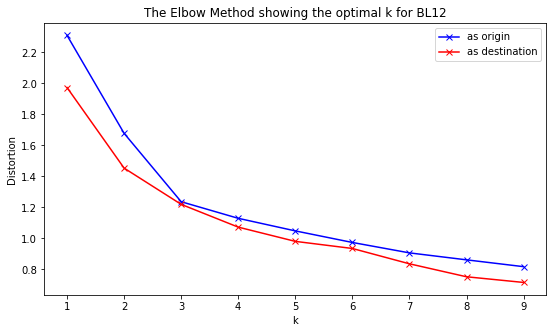

In [12]:
station_elbow(od_total,'BL12', range(1,10))

In [36]:
#II Elbow method for multiple stations

def code_list():
    station_code = []
    for filename in os.listdir('D:/OBS/捷運分時/time_by_od'):
        if filename.split('_')[0] not in station_code:
            station_code.append(filename.split('_')[0])
    return station_code


def multi_elbow(line):
    elbow_result = {}
    from_dict = {}
    to_dict = {}
    colist = code_list()
    
    for od in colist:
        if re.match(line, od):
            sys.stdout.write('\rprocessing {}'.format(od))
            refined_od_from = '{}_'.format(od)
            elbow_from = run_elbow(od_total, refined_od_from, range(1,10))
            from_dict[refined_od_from] = elbow_from
            
            refined_od_to = '_{}'.format(od)
            elbow_to = run_elbow(od_total, refined_od_to, range(1,10))
            to_dict[refined_od_to] = elbow_to
            
        elbow_result['from'] = from_dict
        elbow_result['to'] = to_dict
            
    return elbow_result

def multi_plot(distortions,distortions_to, K, col_num, filename):   
    if len(distortions) % col_num == 0:
        heigh = int(len(distortions)/col_num)
    else:
        heigh = int(len(distortions)/col_num) + 1
            
    #print(len(distortions), heigh)       
    fig, ax = plt.subplots(heigh,col_num,figsize = (11*col_num,8*heigh))   
    fig.subplots_adjust(hspace = .3)
    
    count = 0
    for k,v in distortions.items():
        location_y = int(count%col_num)
        location_x = int(count/col_num)
        ax[location_x,location_y].plot(K, distortions[k], 'bx-', color='blue',label = 'as origin')

        k_to = '_' + k.replace('_','')
        ax[location_x,location_y].plot(K, distortions_to[k_to], 'bx-', color='red', label = 'as destination')
        
        ax[location_x,location_y].set_xlabel('k')
        ax[location_x,location_y].set_ylabel('Distortion')
        ax[location_x,location_y].set_title('The Elbow Method showing the optimal k for {}'.format(k))
        ax[location_x,location_y].legend()
        count += 1
    plt.savefig(filename)
    plt.show()
#fromBL = multi_elbow()



In [10]:
def get_slope(distortions):
    m_dict = {}
    for k,v in distortions.items():
        for i in range(len(v)):
            if i < len(v)-1:
                m = v[i+1] - v[i]
                m_dict.setdefault(k, []).append(m)
    return m_dict

def get_K(slope_dict):
    k_dict = {}
    for k,v in slope_dict.items():
        diff_list = []
        for i in range(len(v)):
            if i < len(v)-1:
                diff = v[i+1] - v[i]
                diff_list.append(diff)
        # the 1st slope is the difference btw k=1 and k=2 , 
        # the 1st slope difference is the difference btw k1&k2 k2&k3, 
        # if the 1st slope differnce is the largest, the will be the slope difference btw k1&2, k2&3, 
        # as the result, the suggested k will be 2, will be i + 2 
        suggest_k = [i for i, j in enumerate(diff_list) if j == max(diff_list)][0] + 2
        k_dict[k] = suggest_k
    return k_dict
#get_slope(R['from'])


In [13]:
#get k-means distortion based on elbow method

#line_list = ['BL', 'BR', 'R', 'G', 'O']
line_list = ['G']
distortions_by_line = {}
for line in line_list:
    print('processing {}'.format(line))
    elbow = multi_elbow(line)
    distortions_by_line[line] = elbow
    

#multi_plot(R['from'],R['to'],range(1,10),4,'K in Red Lines')
#get_K(get_slope(R['to']))

processing G
processing G19A

processing BL

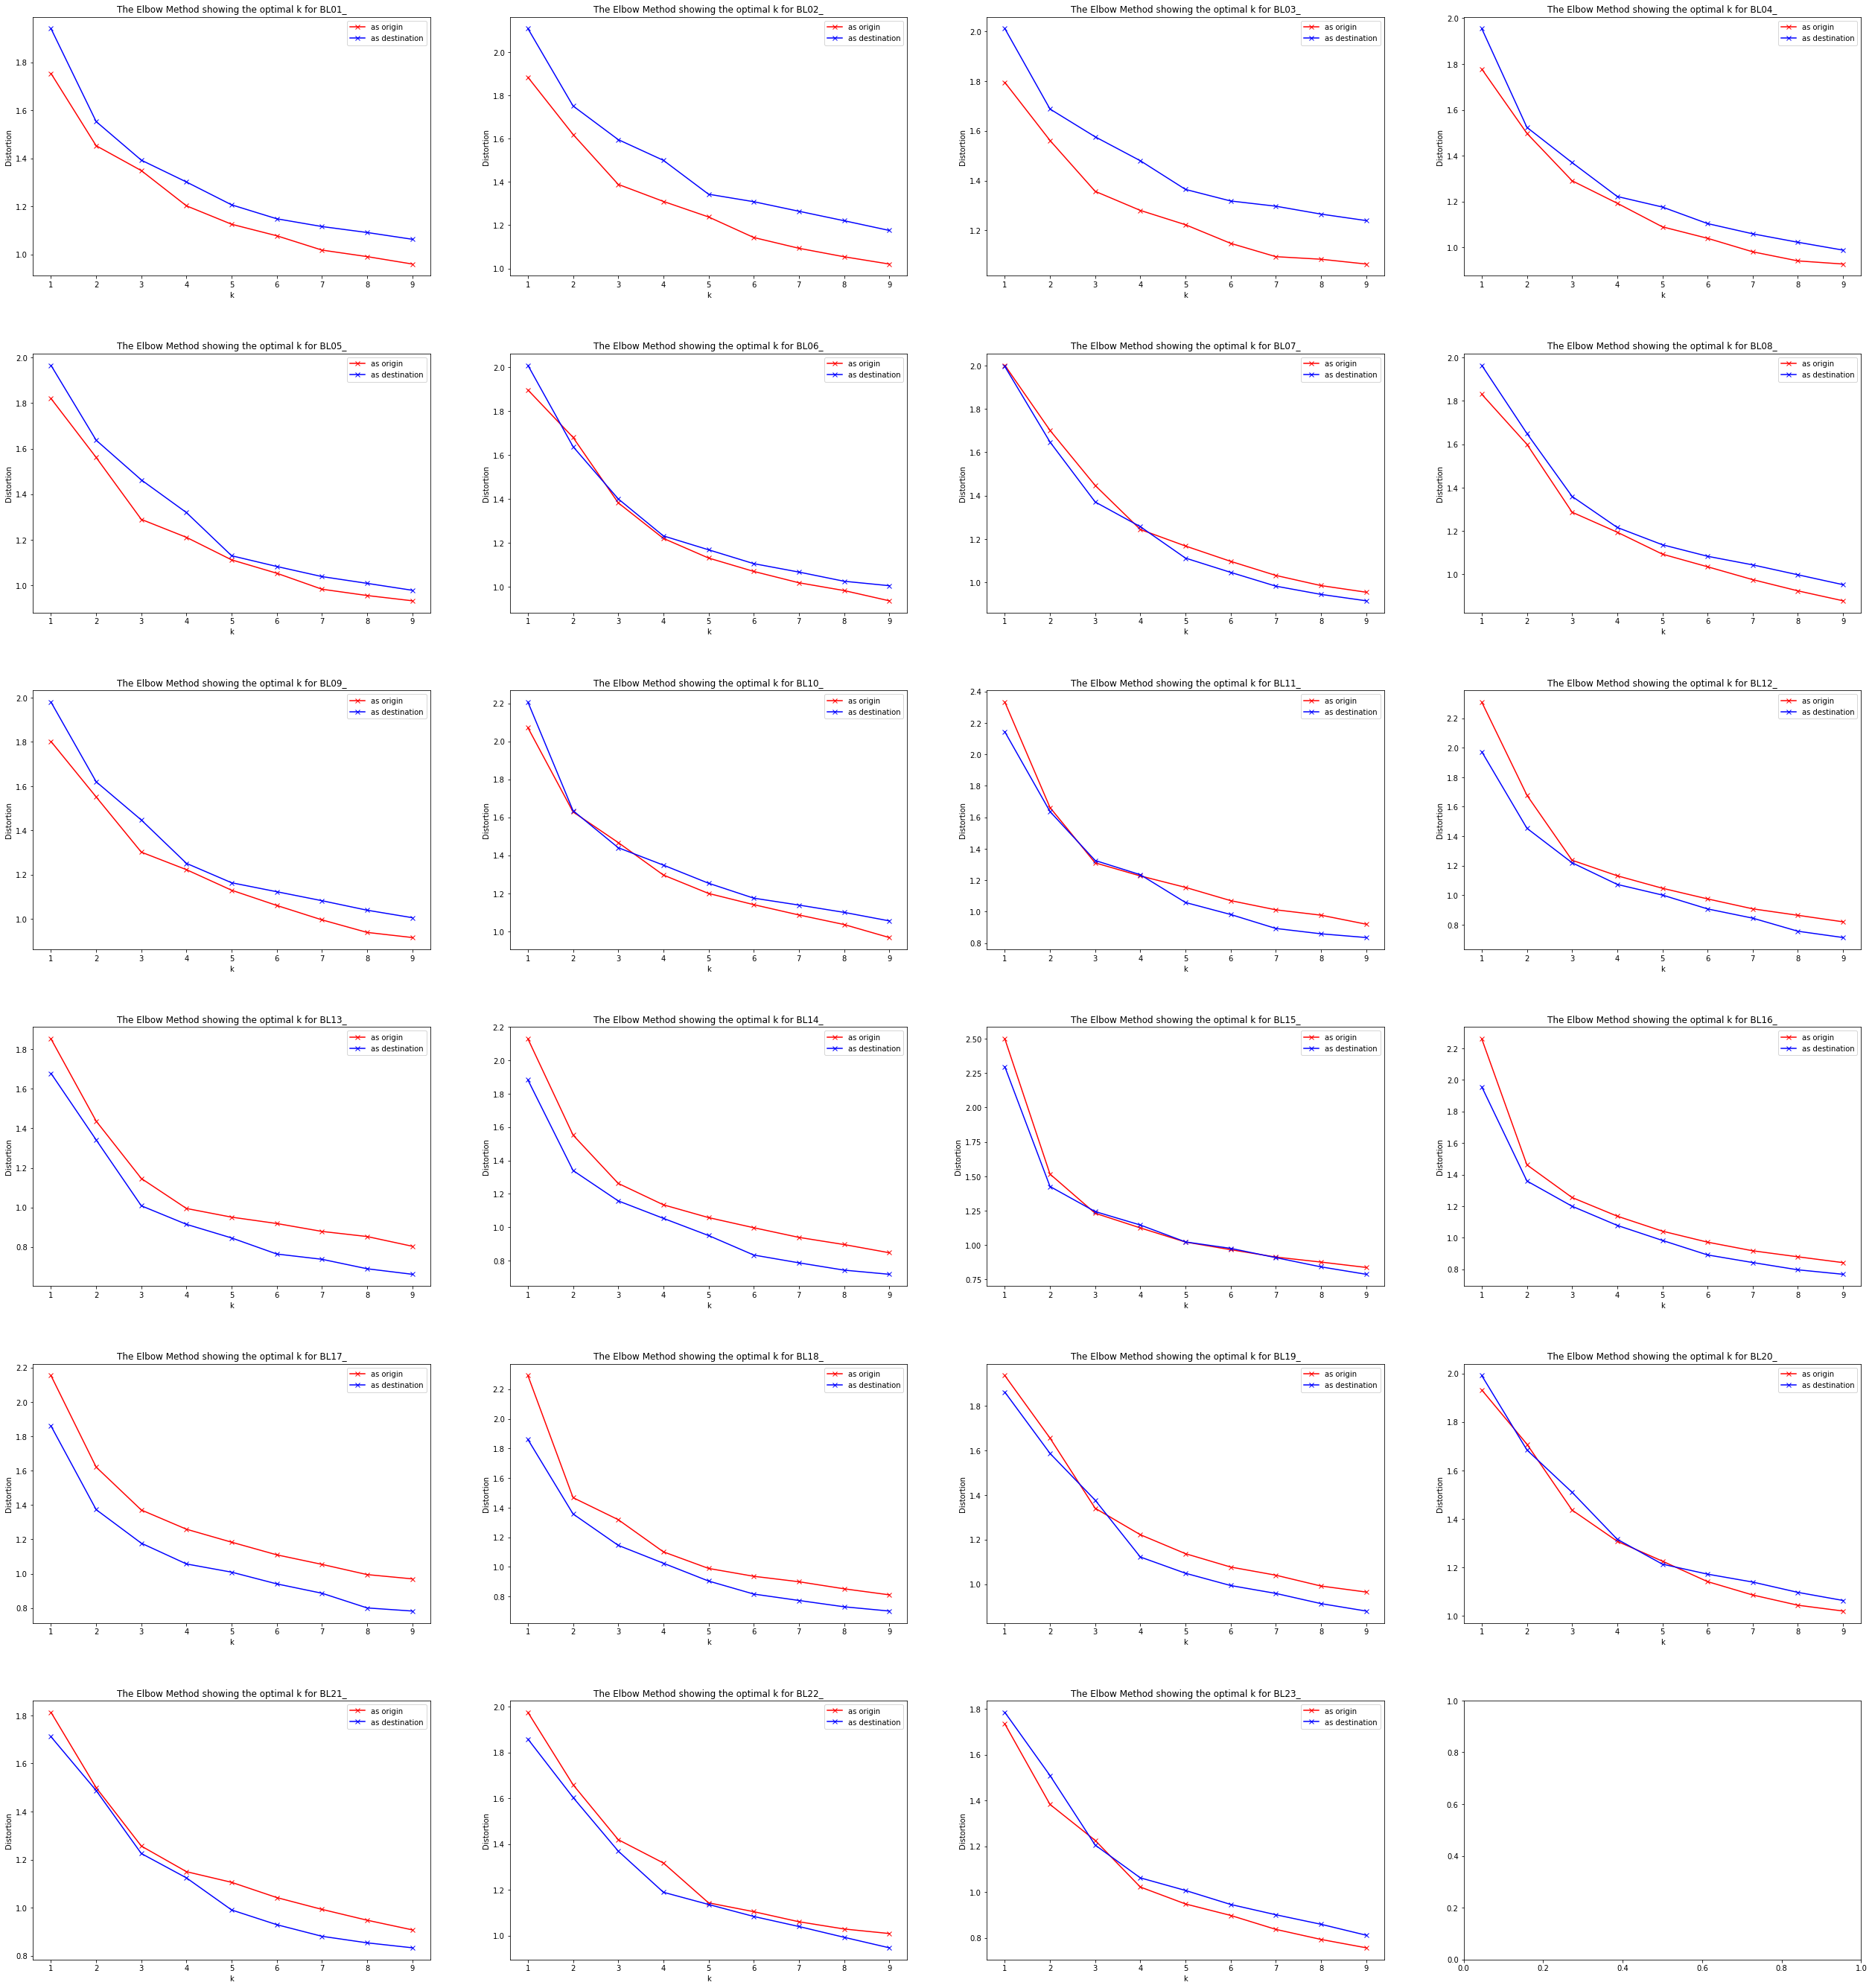

processing BR

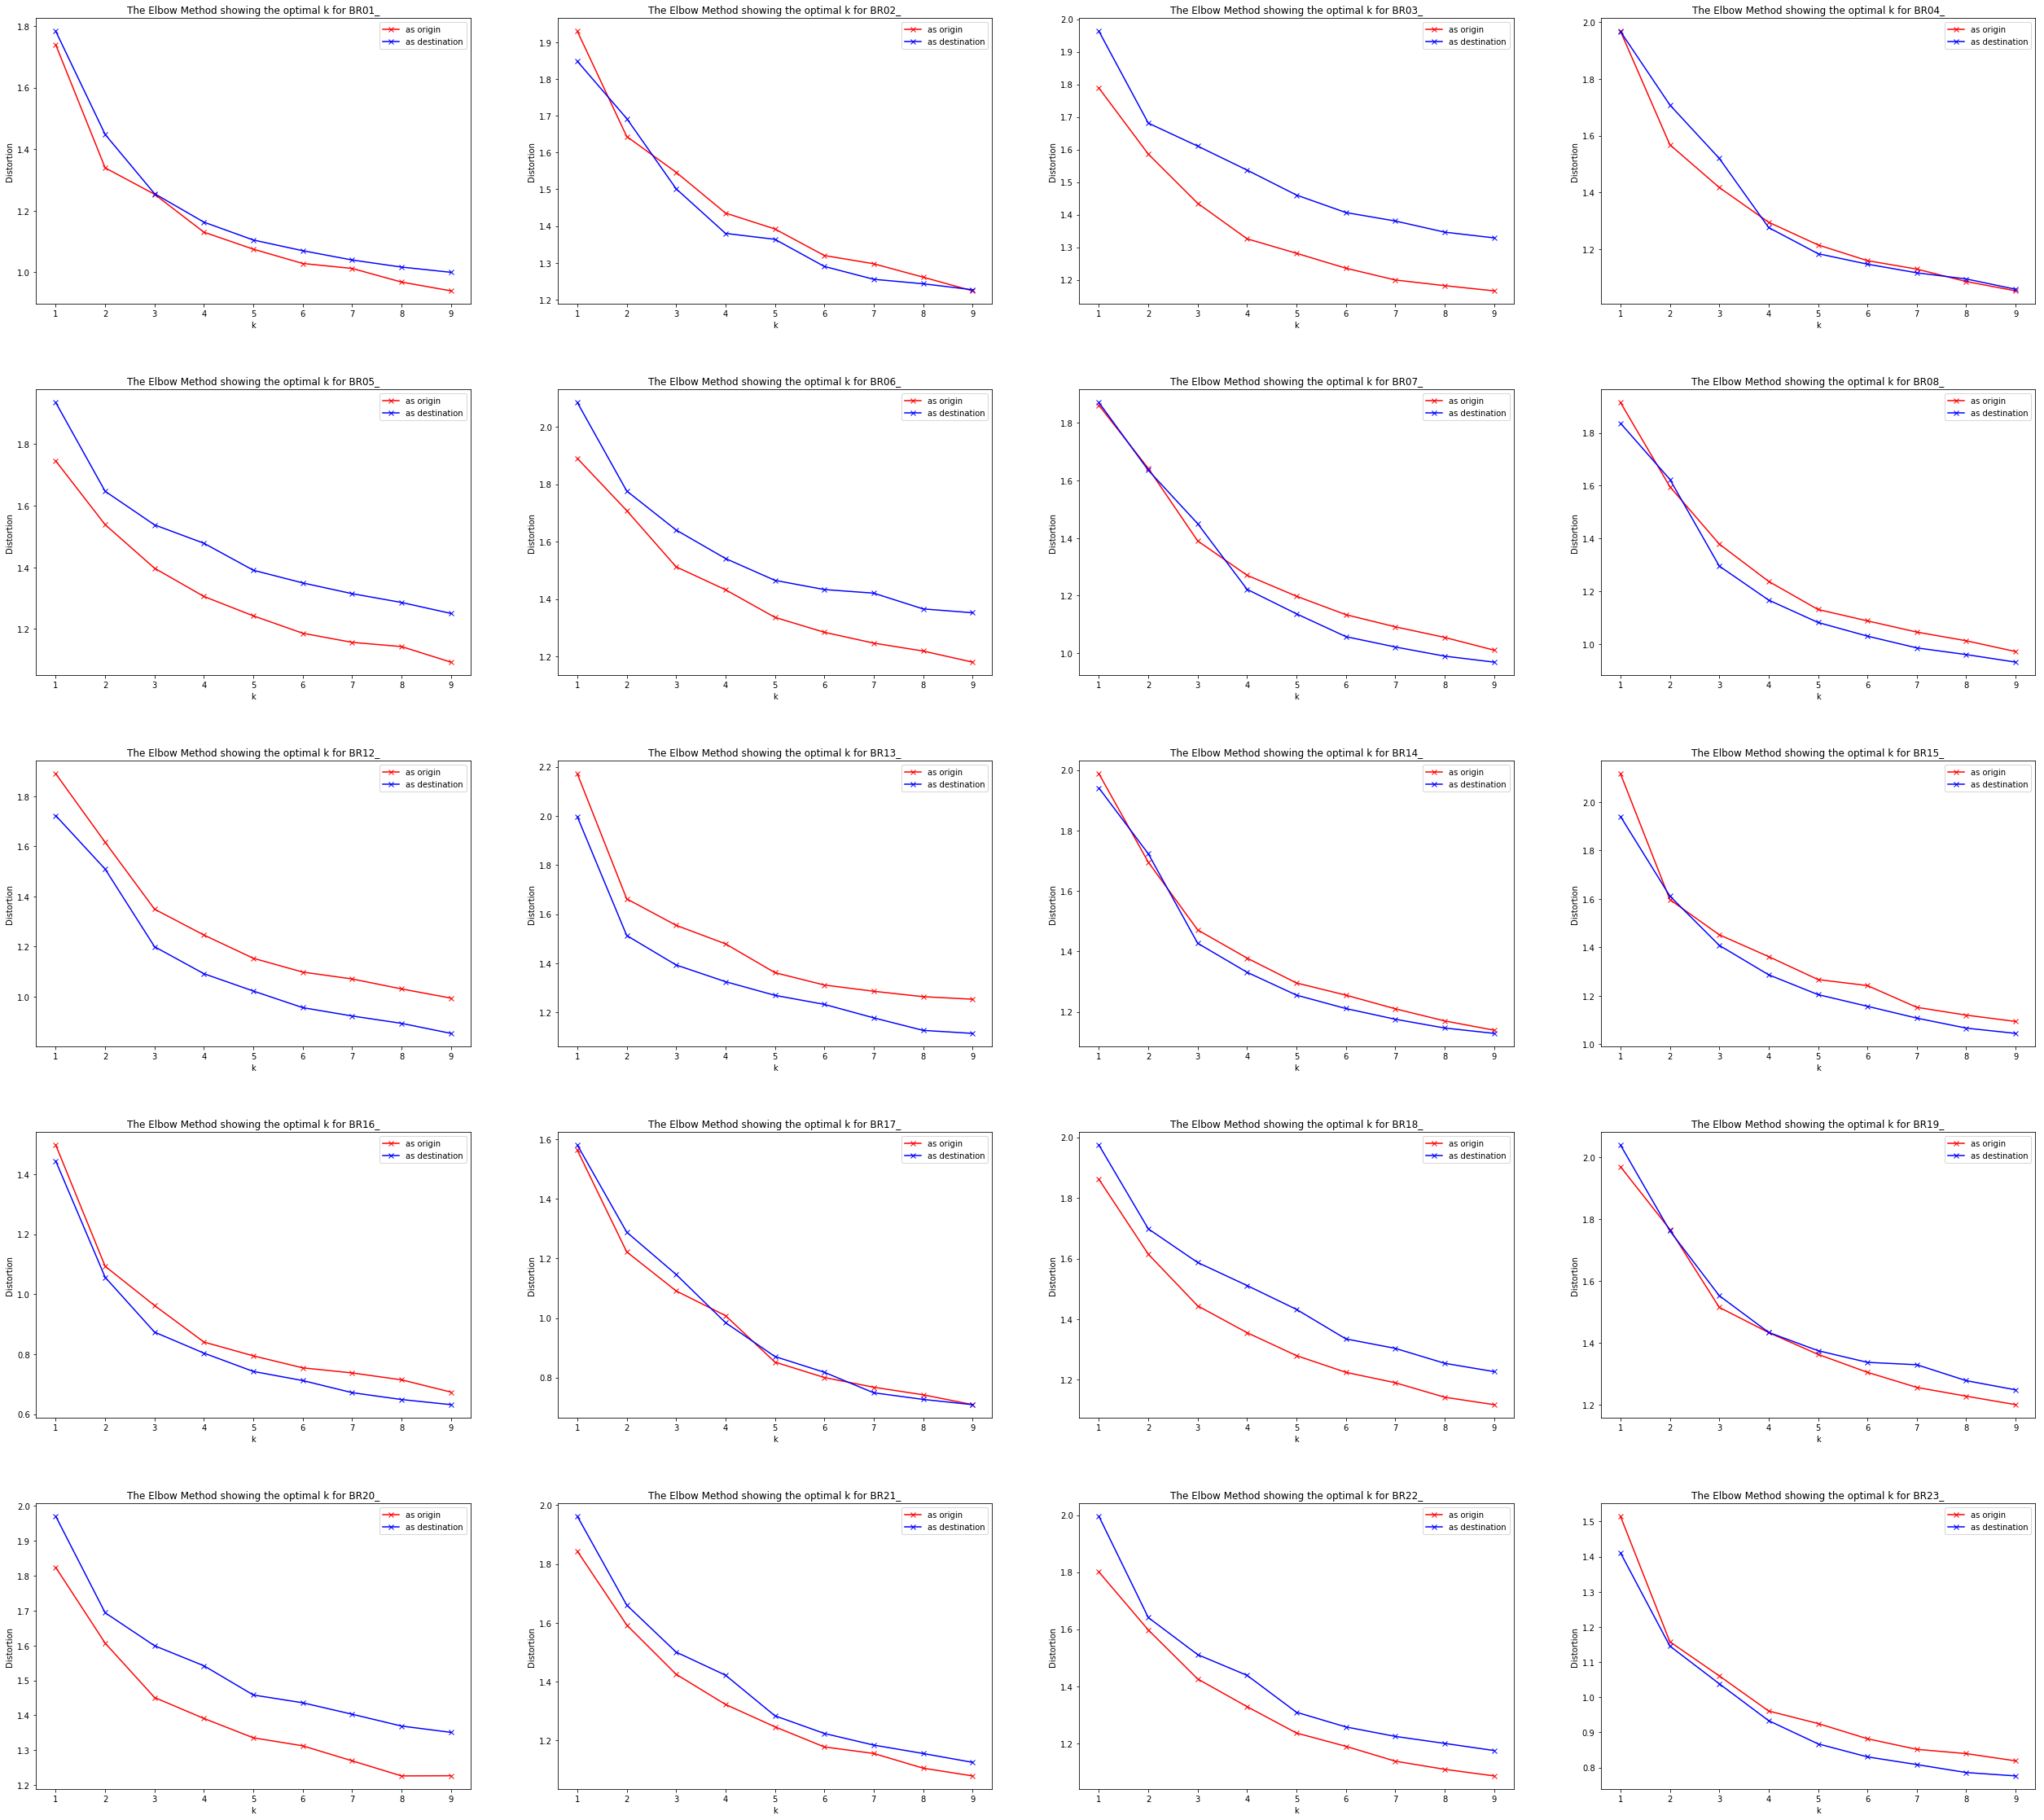

processing R

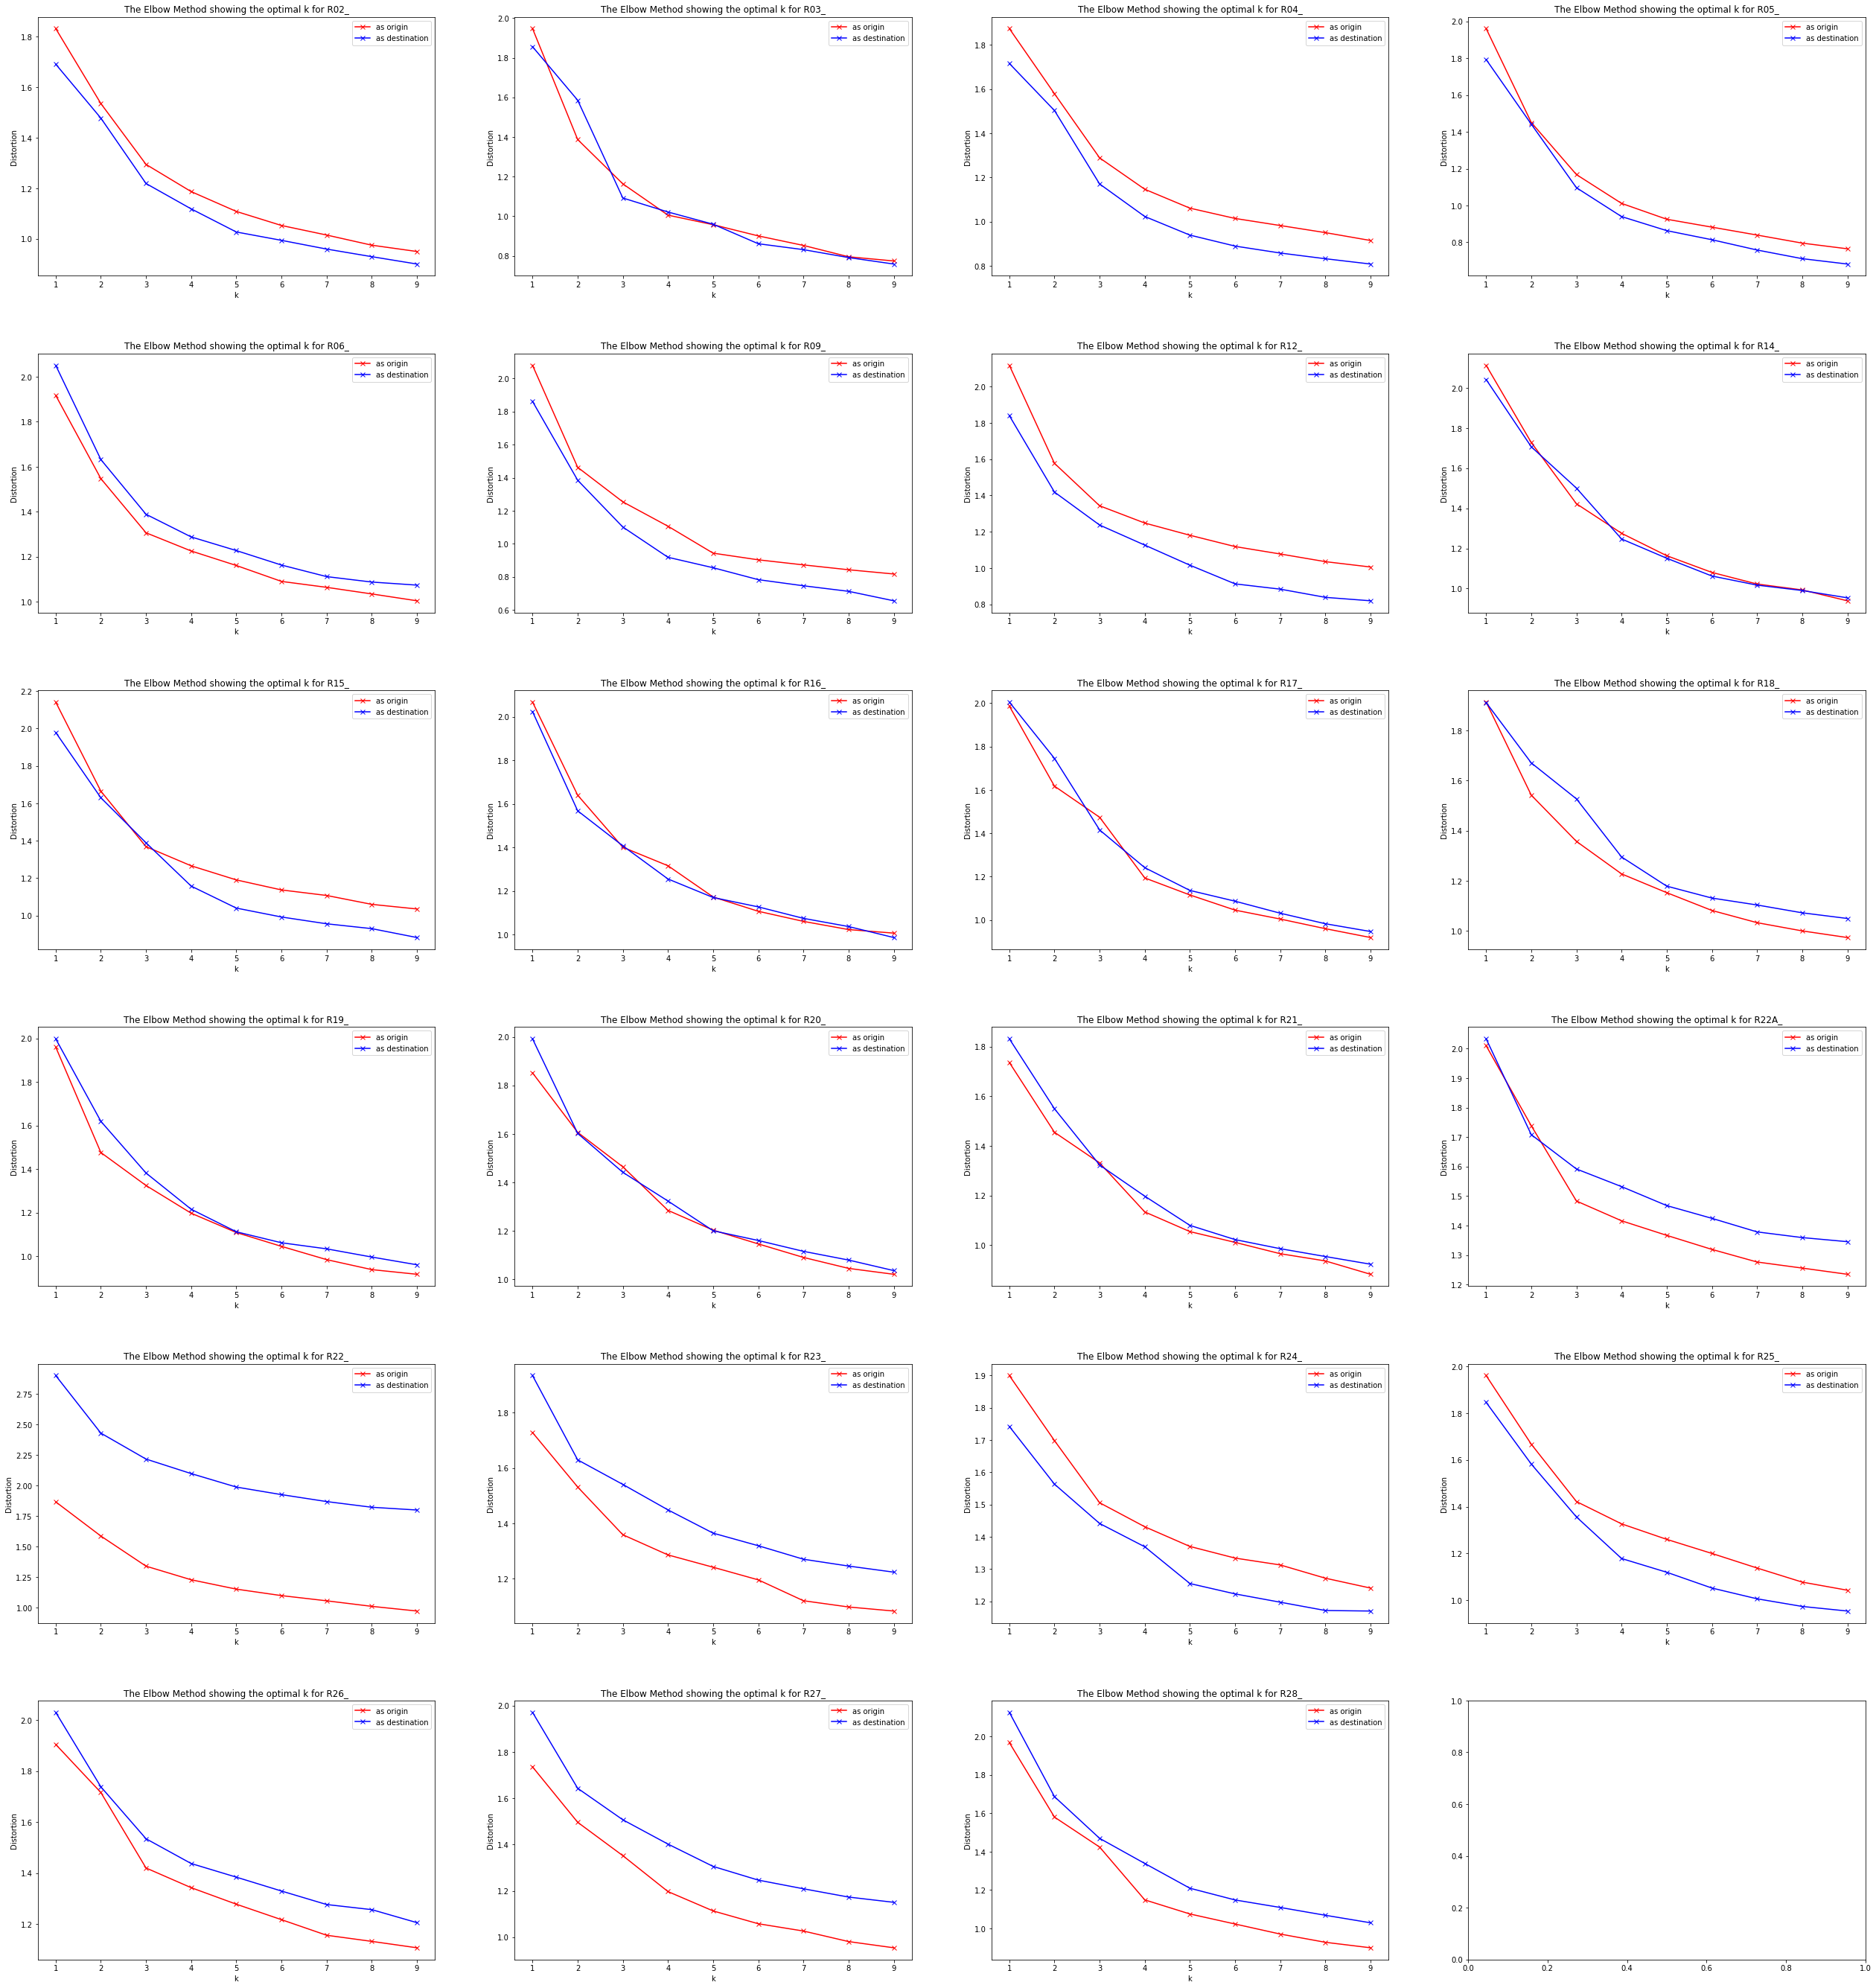

processing G

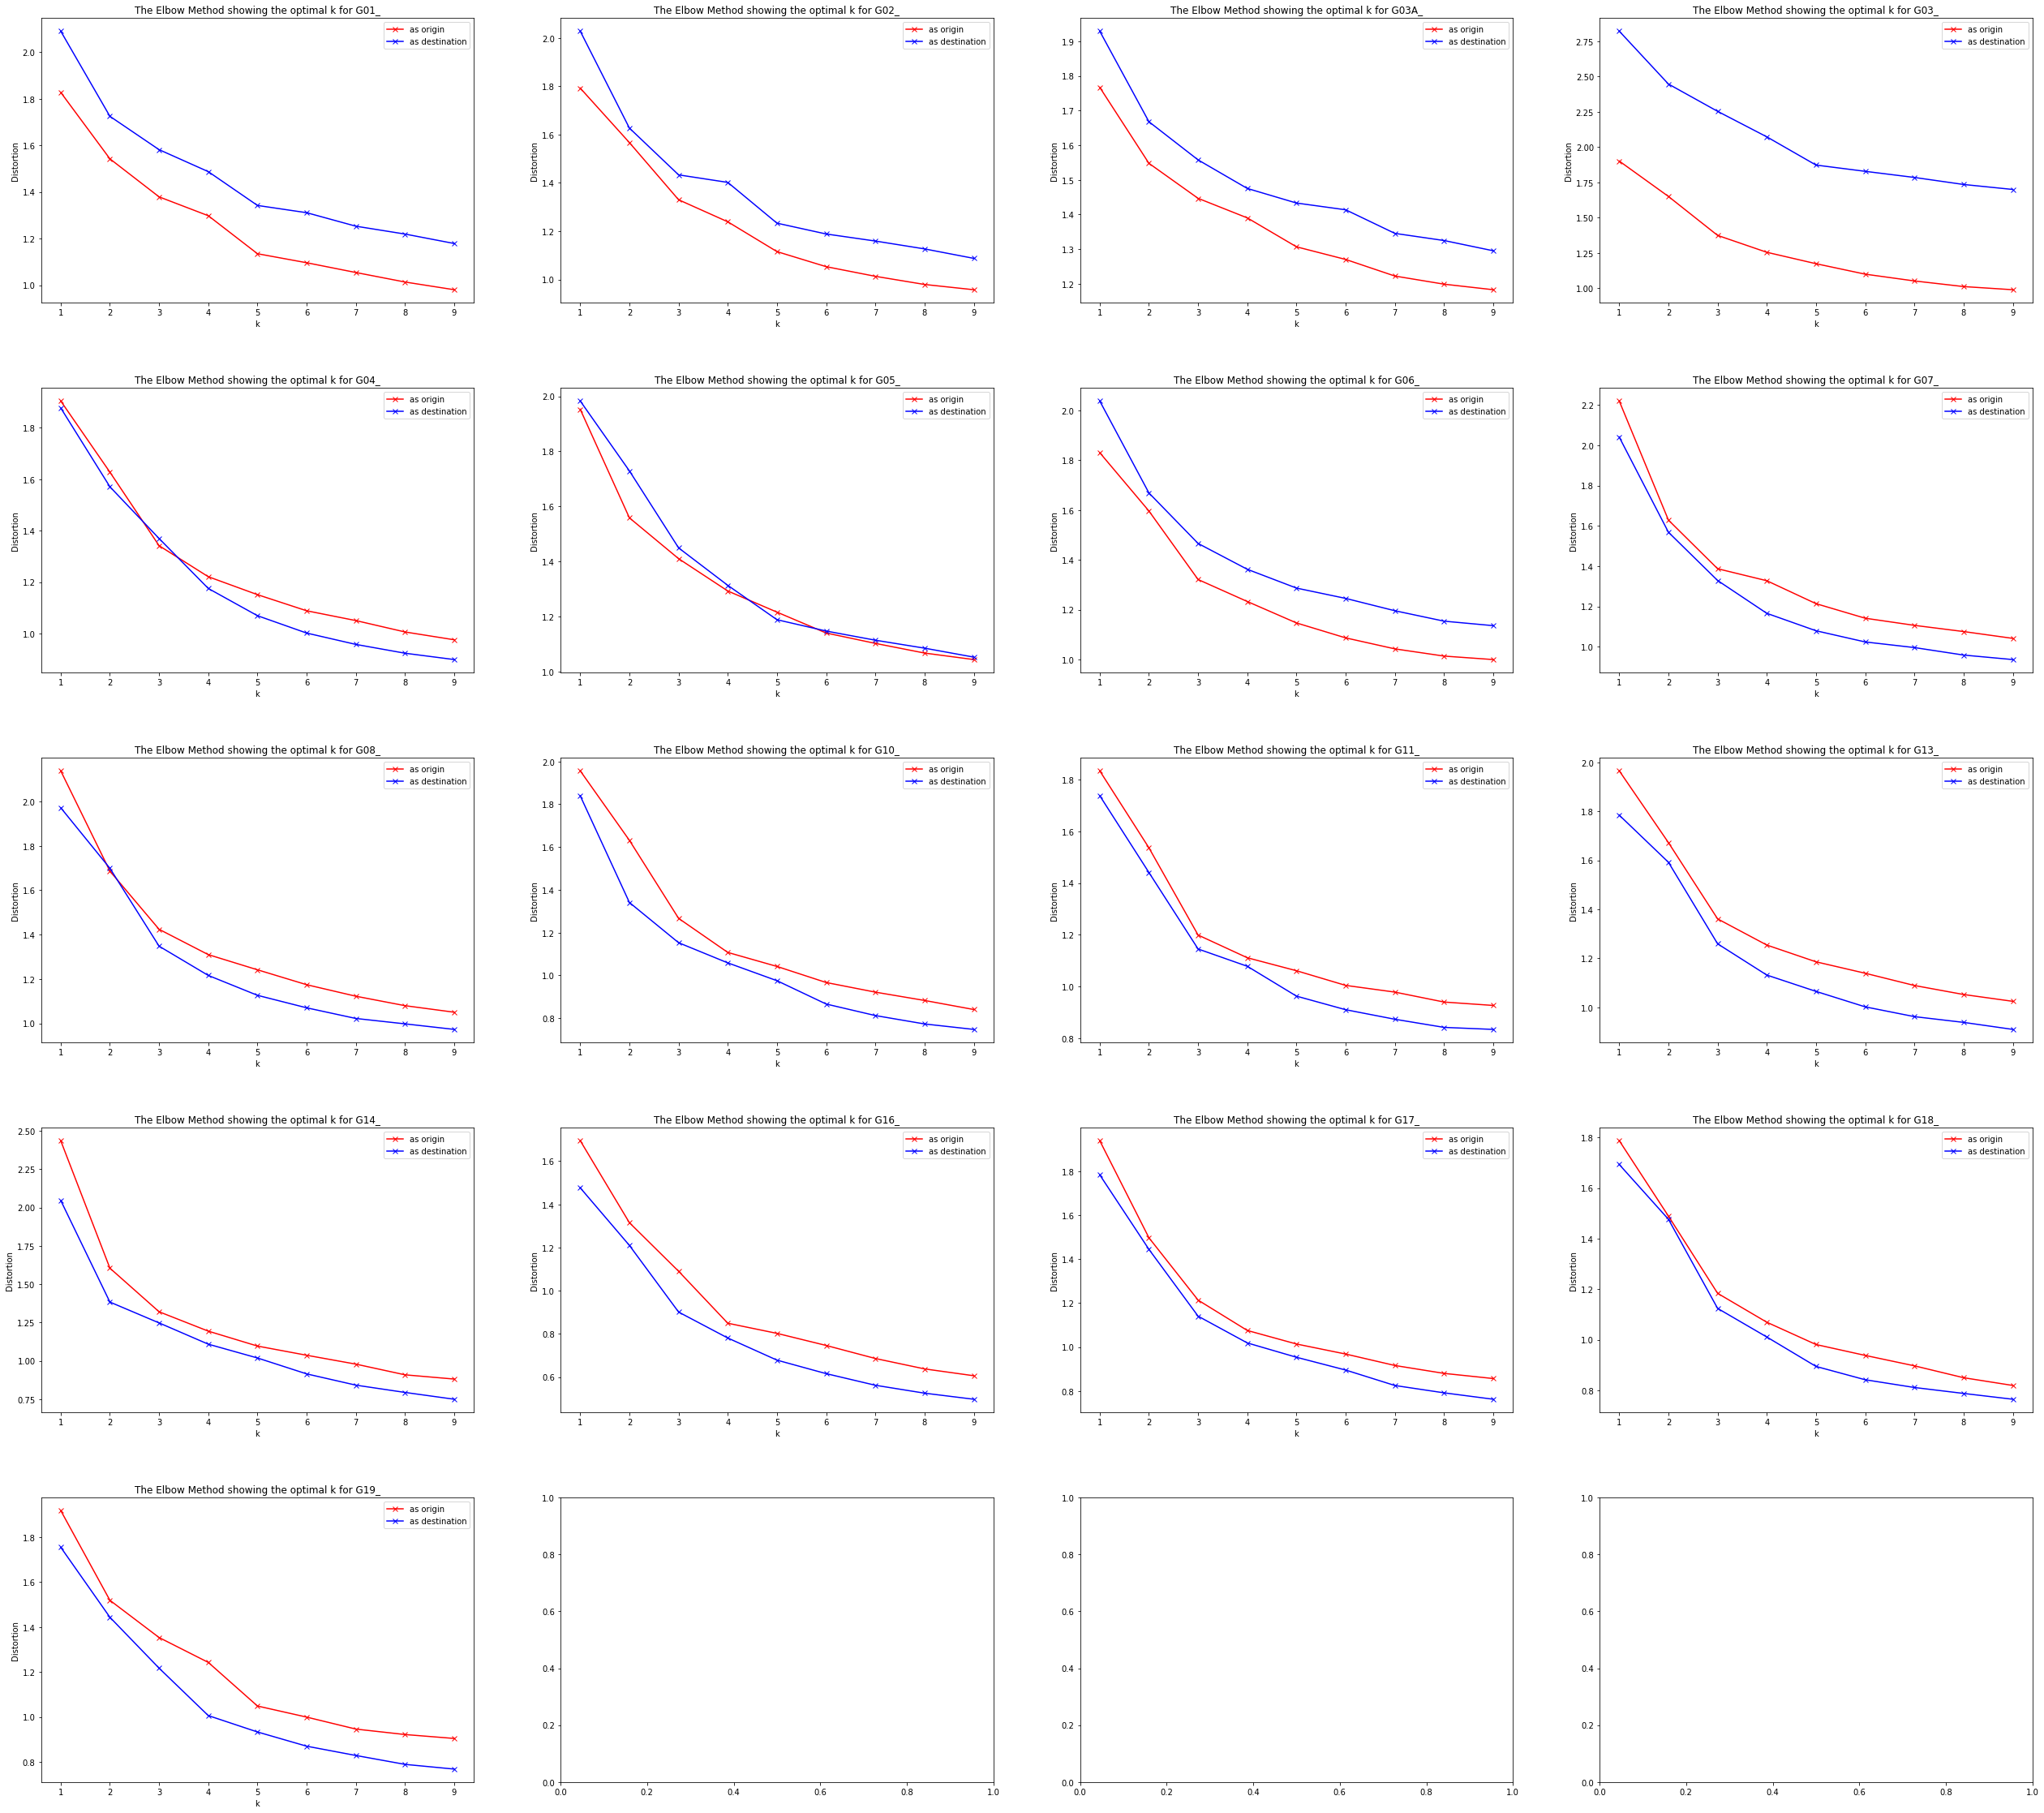

processing O

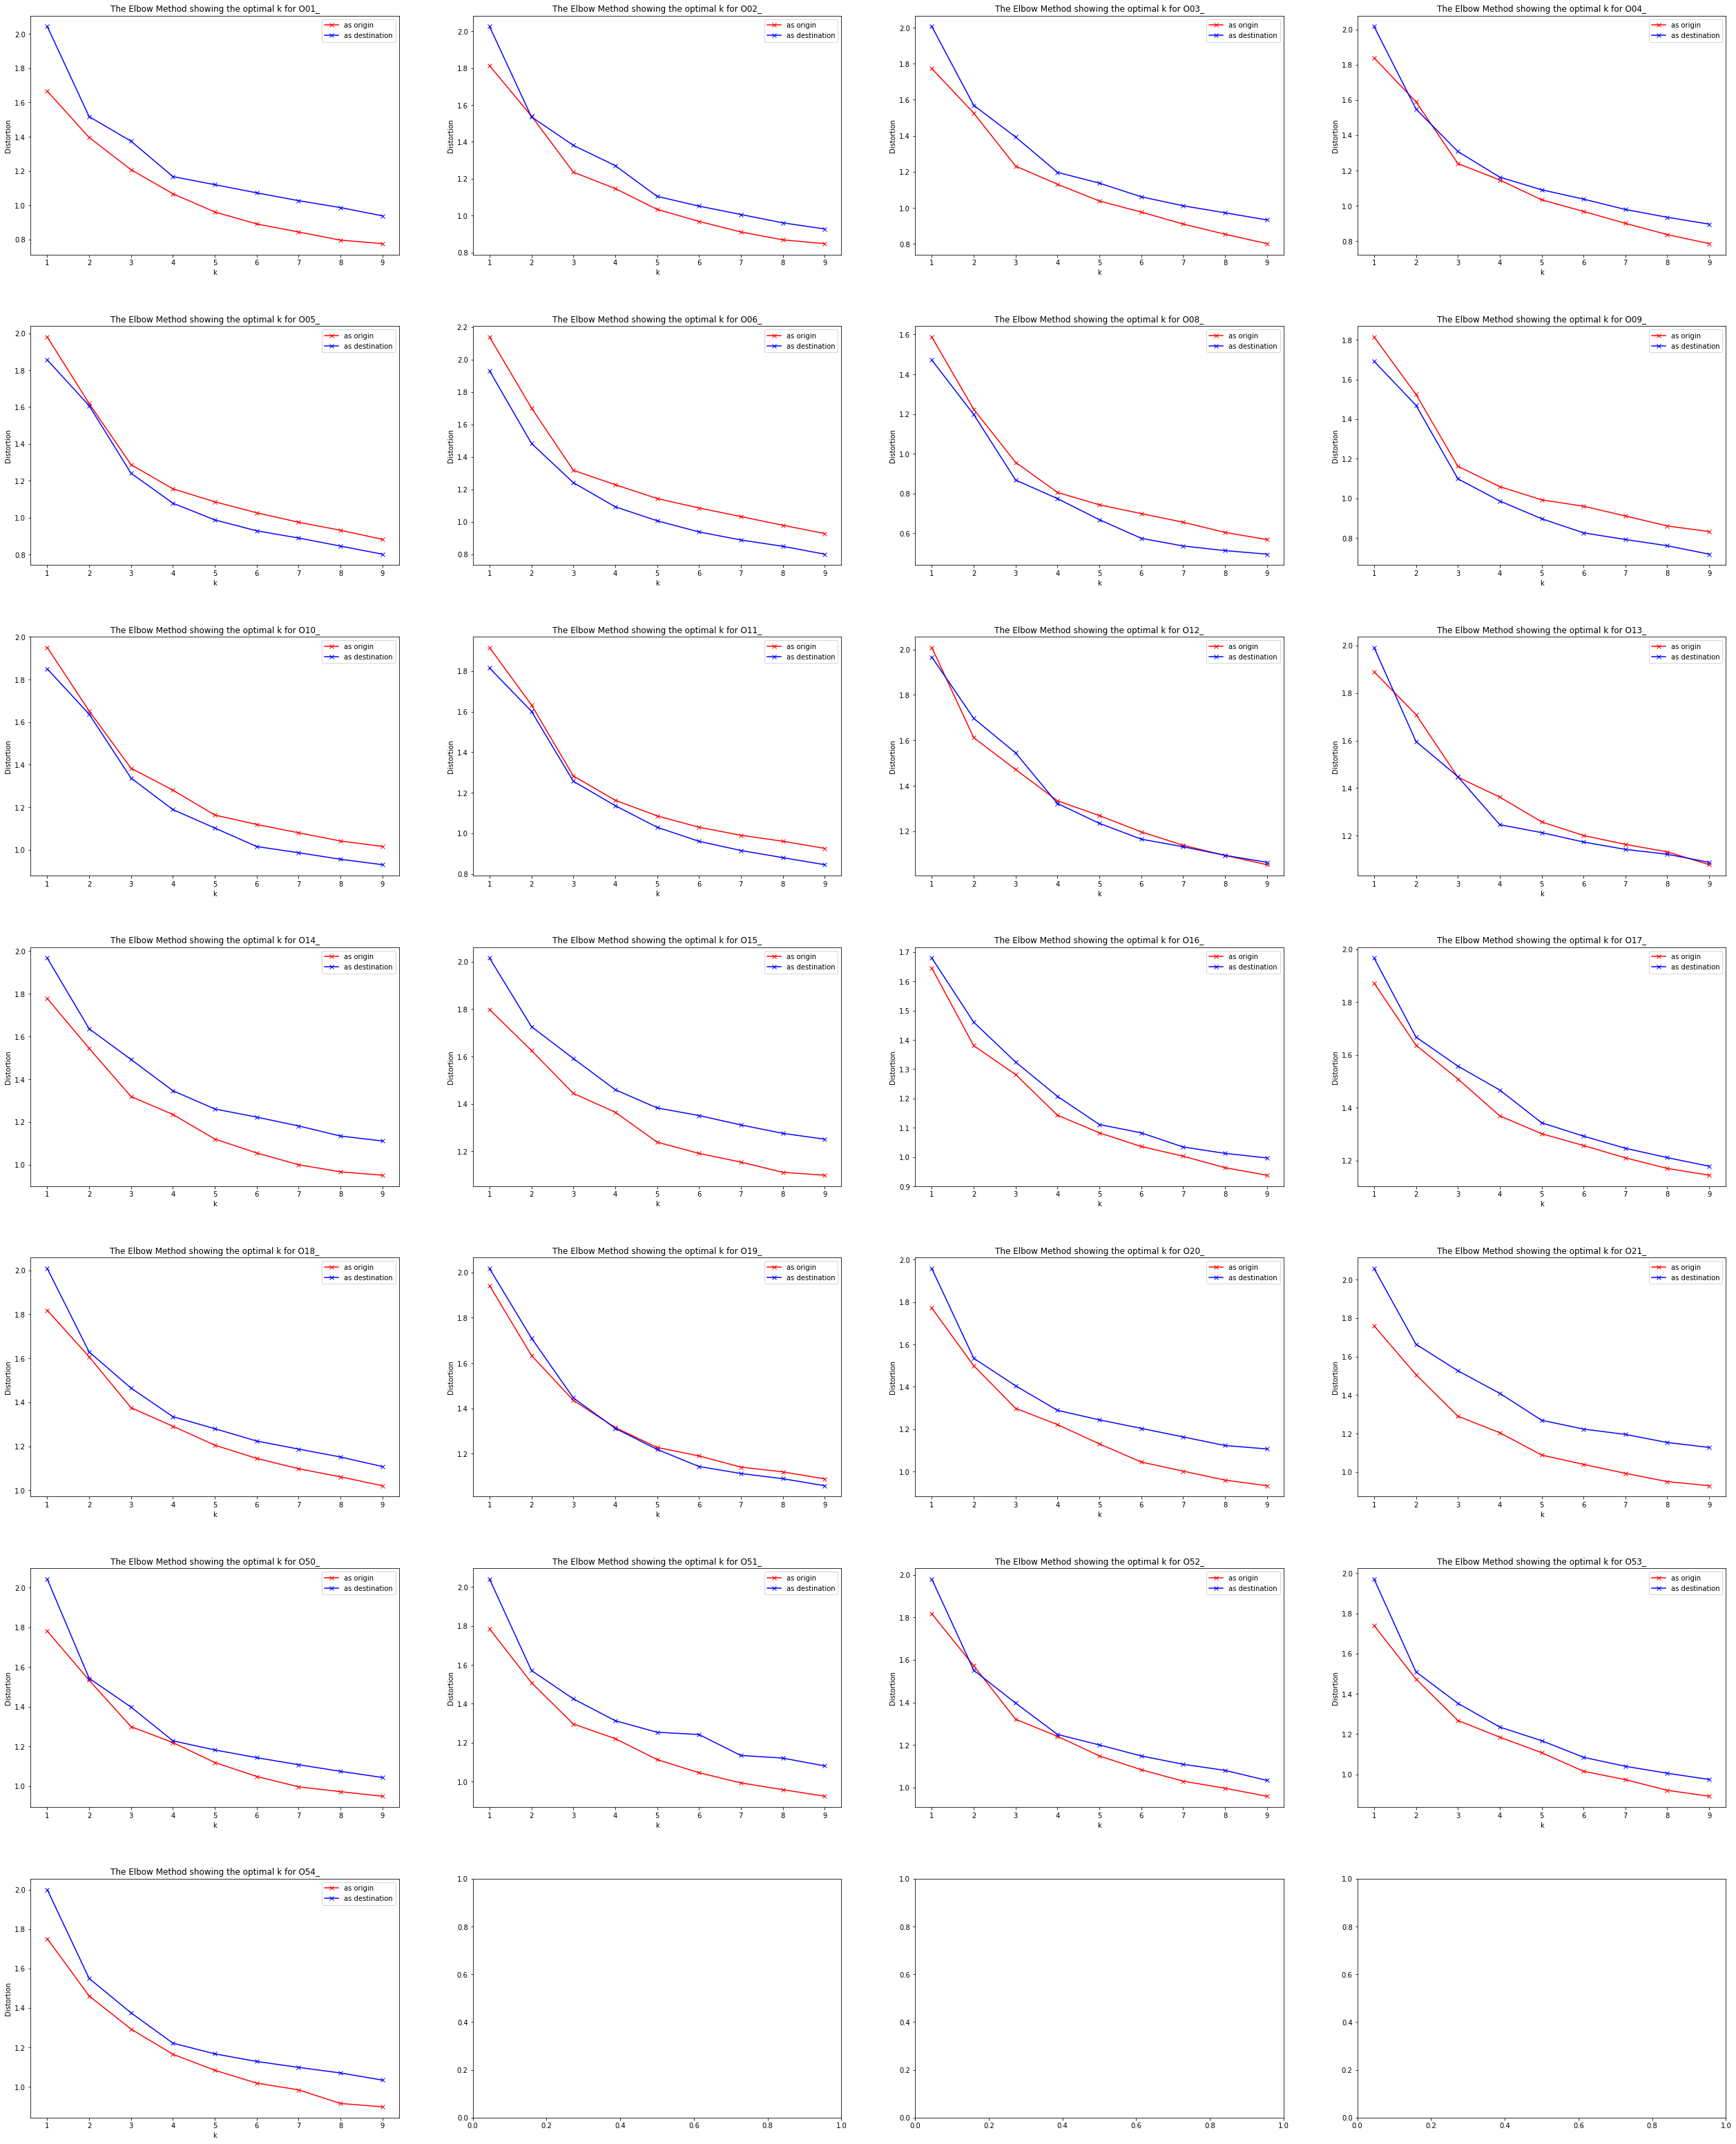

In [460]:
#get suggested K
k_suggest_all = {}
for line,v in distortions_by_line.items():
    for direction,v2 in v.items():
        k_suggest_all.update(get_K(get_slope(v2)))

#elbow visualization
for line,v in distortions_by_line.items():
    sys.stdout.write('\rprocessing {}'.format(line))
    multi_plot(v['from'],v['to'],range(1,10),4,'K in {} Lines'.format(line))